# Customer Clustering Analysis

This notebook clusters customers into 5 distinct shopper classes based on their purchasing behavior using K-Means clustering.

## Objectives:
1. Load and merge customer, order, and sales data
2. Create behavioral features from transaction data
3. Scale features appropriately for clustering
4. Determine optimal number of clusters (Elbow method)
5. Apply K-Means clustering to segment customers into 5 shopper classes
6. Evaluate clustering quality with multiple metrics
7. Analyze cluster characteristics and create visualizations


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 1: Load and Explore Data


In [6]:
# Load all three datasets
customers_df = pd.read_excel(r'C:\Users\GSI\Desktop\DataWareHouse\Customers_f.xlsx')
orders_df = pd.read_excel(r'C:\Users\GSI\Desktop\DataWareHouse\Orders.xlsx')
sales_df = pd.read_excel(r'C:\Users\GSI\Desktop\DataWareHouse\Sales.xlsx')

print("âœ“ Data loaded successfully!")
print(f"\nCustomers shape: {customers_df.shape}")
print(f"Orders shape: {orders_df.shape}")
print(f"Sales shape: {sales_df.shape}")

# Display basic info
print("\n" + "="*80)
print("CUSTOMERS DATA")
print("="*80)
print(customers_df.head())
print(f"\nColumns: {customers_df.columns.tolist()}")
print(f"Data types:\n{customers_df.dtypes}")

print("\n" + "="*80)
print("ORDERS DATA")
print("="*80)
print(orders_df.head())
print(f"\nColumns: {orders_df.columns.tolist()}")

print("\n" + "="*80)
print("SALES DATA")
print("="*80)
print(sales_df.head())
print(f"\nColumns: {sales_df.columns.tolist()}")


âœ“ Data loaded successfully!

Customers shape: (3900, 10)
Orders shape: (500, 3)
Sales shape: (502500, 12)

CUSTOMERS DATA
   code_customer  Age Gender                   Zip_code Preferred_size  \
0              1   55   Male         Lexington_Kentucky              L   
1              2   19   Male               Auburn_Maine              L   
2              3   50   Male  Springfield_Massachusetts              S   
3              4   21   Male      Cranston_Rhode Island              M   
4              5   45   Male              Eugene_Oregon              M   

   Overall_review Subscription Status  Previous Purchases Payment Method  \
0             3.1                 Yes                  14          Venmo   
1             3.1                 Yes                   2           Cash   
2             3.1                 Yes                  23    Credit Card   
3             3.5                 Yes                  49         PayPal   
4             2.7                 Yes              

In [9]:
# Debug: Check columns in sales_df
print("Sales DF columns:")
print(sales_df.columns.tolist())
print("\nFirst few rows of sales_df:")
print(sales_df.head())
print("\nOrders DF columns:")
print(orders_df.columns.tolist())
print("\nFirst few rows of orders_df:")
print(orders_df.head())

Sales DF columns:
['code_sale', 'code_customer', 'code_order', 'SKU', 'code_ship_type', 'code_pricing_strategy', 'code_payment_method', 'quantity', 'prod_name', 'Estimated_Unit_Price', 'sale_date', 'is_discounted']

First few rows of sales_df:
  code_sale  code_customer code_order        SKU code_ship_type  \
0   S244495           2060  ORD293053  118458034       SHIP1209   
1   S279244            125  ORD256641  118458034       SHIP4965   
2   S519880           1989  ORD979201  144993001       SHIP4965   
3   S395741            839  ORD276138  126589012       SHIP3159   
4   S558471           1179  ORD686096  118458004       SHIP4965   

  code_pricing_strategy code_payment_method  quantity               prod_name  \
0            TOPBAN0041             PAY1961         1    Jerry jogger bottoms   
1            BOTH&M0012             PAY0503         3    Jerry jogger bottoms   
2            OUTZAR0031             PAY1985         1  Mama 100 den 1p Tights   
3            OUTMAN0029      

## Step 2: Data Preprocessing and Feature Engineering


In [4]:
# Clean and preprocess data
# Fix decimal separator in Overall_review (comma to dot)
if 'Overall_review' in customers_df.columns:
    customers_df['Overall_review'] = customers_df['Overall_review'].astype(str).str.replace(',', '.').astype(float)

# Fix decimal separator in Estimated_Unit_Price
if 'Estimated_Unit_Price' in sales_df.columns:
    sales_df['Estimated_Unit_Price'] = sales_df['Estimated_Unit_Price'].astype(str).str.replace(',', '.').astype(float)

# Convert sale_date to datetime
if 'sale_date' in sales_df.columns:
    sales_df['sale_date'] = pd.to_datetime(sales_df['sale_date'], errors='coerce')

print("âœ“ Data preprocessing completed!")


âœ“ Data preprocessing completed!


In [ ]:
# Create customer behavior features from sales data
customer_features = sales_df.groupby('code_customer').agg({
    'code_sale': 'count',  # Total number of purchases
    'quantity': 'sum',     # Total quantity purchased
    'Estimated_Unit_Price': ['mean', 'sum'],  # Average and total spending
    'is_discounted': 'mean',  # Discount usage rate
    'sale_date': ['min', 'max']  # First and last purchase dates
}).reset_index()

# Flatten column names
customer_features.columns = ['code_customer', 'total_purchases', 'total_quantity', 
                              'avg_unit_price', 'total_spent', 'discount_rate', 
                              'first_purchase', 'last_purchase']

# Calculate customer lifetime (days since first purchase)
customer_features['customer_lifetime_days'] = (
    customer_features['last_purchase'] - customer_features['first_purchase']
).dt.days
customer_features['customer_lifetime_days'] = customer_features['customer_lifetime_days'].fillna(0)

# Calculate purchase frequency (purchases per month)
customer_features['purchase_frequency'] = customer_features['total_purchases'] / (
    (customer_features['customer_lifetime_days'] / 30) + 1  # +1 to avoid division by zero
)

# Calculate average order value
customer_features['avg_order_value'] = customer_features['total_spent'] / customer_features['total_purchases']

# Merge with customer demographic data
customer_features = customer_features.merge(customers_df, on='code_customer', how='left')

# Create order status features
order_status_features = orders_df.groupby('order_code').agg({
    'status_label': 'first',
    'reason': lambda x: 1 if pd.notna(x.iloc[0]) else 0  # Has return/cancel reason
}).reset_index()

# Merge order status with sales
sales_with_status = sales_df.merge(order_status_features, left_on='code_order', right_on='order_code', how='left')

# Calculate return/cancel rate per customer
customer_order_stats = sales_with_status.groupby('code_customer').agg({
    'status_label': lambda x: (x == 'Returned').sum() + (x == 'Cancelled').sum(),
    'code_sale': 'count'
}).reset_index()
customer_order_stats.columns = ['code_customer', 'returned_cancelled', 'total_orders']
customer_order_stats['return_cancel_rate'] = customer_order_stats['returned_cancelled'] / customer_order_stats['total_orders']

# Merge with customer features
customer_features = customer_features.merge(customer_order_stats[['code_customer', 'return_cancel_rate']], 
                                            on='code_customer', how='left')
customer_features['return_cancel_rate'] = customer_features['return_cancel_rate'].fillna(0)

print("âœ“ Feature engineering completed!")
print(f"\nFinal feature shape: {customer_features.shape}")
print(f"\nFeature columns: {customer_features.columns.tolist()}")
print(f"\nFeature statistics:")
print(customer_features[[
    'total_purchases', 'total_quantity', 'total_spent', 'avg_unit_price',
    'purchase_frequency', 'avg_order_value', 'return_cancel_rate', 'discount_rate'
]].describe().round(2))


KeyError: 'code_order'

## Step 3A: Data Preparation and Visualization (EDA)

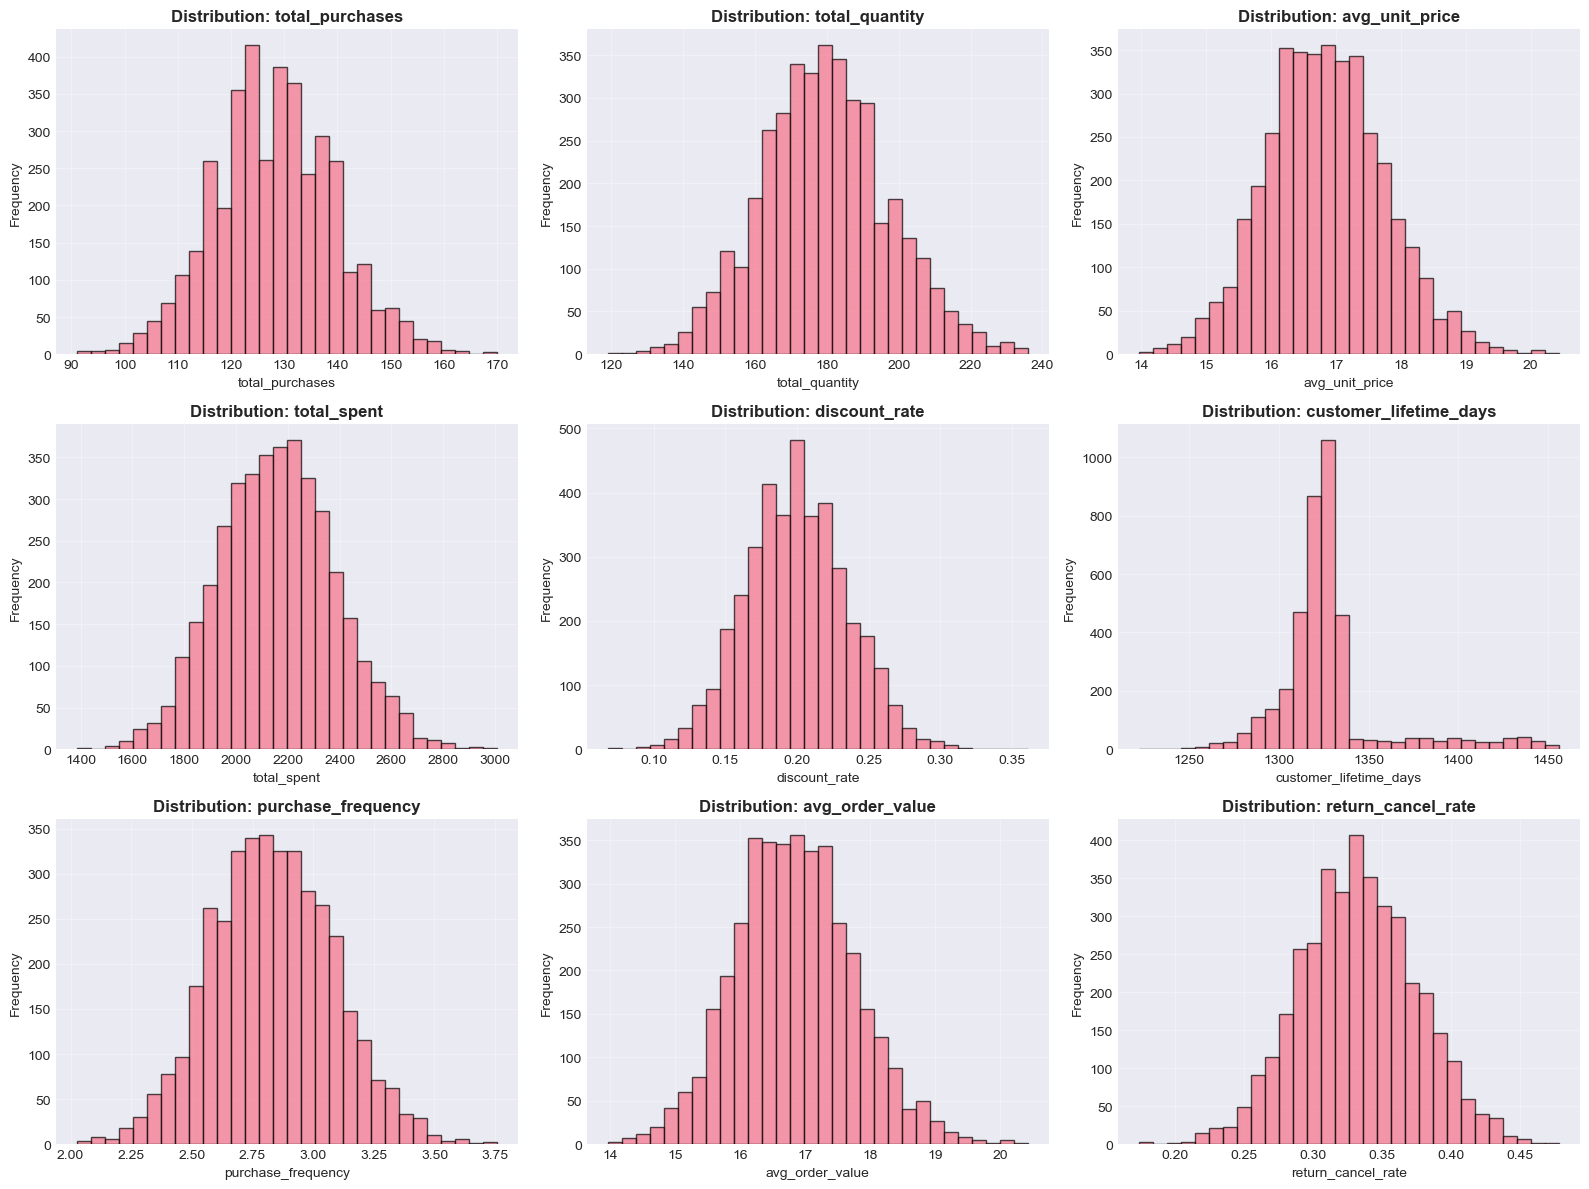

✓ Feature distributions visualized


In [82]:
# Visualize feature distributions before scaling
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

features_to_viz = [
    'total_purchases', 'total_quantity', 'avg_unit_price', 'total_spent',
    'discount_rate', 'customer_lifetime_days', 'purchase_frequency', 'avg_order_value', 'return_cancel_rate'
]

for idx, feature in enumerate(features_to_viz):
    if feature in customer_features.columns:
        axes[idx].hist(customer_features[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution: {feature}', fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Feature distributions visualized")


## Step 3B: Advanced Feature Transformation for Better Clustering

In [83]:
# Define clustering features first
clustering_features = [
    'total_purchases', 'total_quantity', 'avg_unit_price', 'total_spent',
    'discount_rate', 'customer_lifetime_days', 'purchase_frequency',
    'avg_order_value', 'return_cancel_rate'
]

# Apply robust preprocessing: outlier clipping + log transform for skewed features
X_transformed = customer_features[clustering_features].copy()

# Step 1: Clip extreme outliers (1st-99th percentile) to reduce influence of rare cases
for col in X_transformed.columns:
    low, high = np.percentile(X_transformed[col].dropna(), [1, 99])
    X_transformed[col] = X_transformed[col].clip(lower=low, upper=high)

print("✓ Outliers clipped to 1st-99th percentile range")

# Step 2: Apply log1p transform to highly skewed features
# This helps K-Means separate low/high spending and frequency customers
skewed_features = ['total_purchases', 'total_quantity', 'total_spent', 'avg_order_value', 'purchase_frequency']
for feature in skewed_features:
    if feature in X_transformed.columns:
        X_transformed[feature] = np.log1p(X_transformed[feature])

print("✓ Applied log1p transformation to skewed features")
print(f"  Transformed features: {skewed_features}")

# Verify transformations
print("\nFeature statistics after transformation:")
print(X_transformed.describe().round(3))

✓ Outliers clipped to 1st-99th percentile range
✓ Applied log1p transformation to skewed features
  Transformed features: ['total_purchases', 'total_quantity', 'total_spent', 'avg_order_value', 'purchase_frequency']

Feature statistics after transformation:
       total_purchases  total_quantity  avg_unit_price  total_spent  \
count         3900.000        3900.000        3900.000     3900.000   
mean             4.858           5.191          16.840        7.673   
std              0.086           0.097           0.893        0.102   
min              4.644           4.956          14.803        7.415   
25%              4.804           5.124          16.216        7.603   
50%              4.860           5.193          16.817        7.678   
75%              4.920           5.257          17.428        7.744   
max              5.056           5.412          19.075        7.894   

       discount_rate  customer_lifetime_days  purchase_frequency  \
count       3900.000              

## Step 3: Prepare Features for Clustering


In [84]:
# Select features for clustering
clustering_features = [
    'total_purchases', 'total_quantity', 'avg_unit_price', 'total_spent',
    'discount_rate', 'customer_lifetime_days', 'purchase_frequency',
    'avg_order_value', 'return_cancel_rate'
]

# Create feature matrix
X = customer_features[clustering_features].copy()

# Handle missing values
X = X.fillna(X.median())

# Store customer IDs for later reference
customer_ids = customer_features['code_customer'].values

print(f"âœ“ Feature matrix prepared!")
print(f"Feature matrix shape: {X.shape}")
print(f"Number of customers: {len(customer_ids)}")
print(f"Number of features: {len(clustering_features)}")
print(f"\nFeatures for clustering: {clustering_features}")
print(f"\nFeature statistics (before scaling):")
print(X.describe().round(2))


âœ“ Feature matrix prepared!
Feature matrix shape: (3900, 9)
Number of customers: 3900
Number of features: 9

Features for clustering: ['total_purchases', 'total_quantity', 'avg_unit_price', 'total_spent', 'discount_rate', 'customer_lifetime_days', 'purchase_frequency', 'avg_order_value', 'return_cancel_rate']

Feature statistics (before scaling):


       total_purchases  total_quantity  avg_unit_price  total_spent  \
count           3900.0         3900.00         3900.00      3900.00   
mean             128.2          179.50           16.84      2159.28   
std               11.3           17.71            0.91       223.84   
min               91.0          119.00           13.96      1385.09   
25%              121.0          167.00           16.22      2003.49   
50%              128.0          179.00           16.82      2158.74   
75%              136.0          191.00           17.43      2307.71   
max              170.0          236.00           20.43      3008.39   

       discount_rate  customer_lifetime_days  purchase_frequency  \
count        3900.00                 3900.00             3900.00   
mean            0.20                 1327.75                2.83   
std             0.04                   30.75                0.25   
min             0.07                 1222.00                2.03   
25%             0.18

## Step 4: Feature Scaling (StandardScaler)

Normalization using StandardScaler ensures all features have mean=0 and std=1. This is critical for K-Means as it:
- Ensures all features contribute equally regardless of their scale
- Prevents features with larger ranges from dominating the algorithm
- Improves clustering quality and convergence speed


In [85]:
# Apply StandardScaler normalization to the transformed features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features, index=X_transformed.index)

print("✓ Feature scaling completed using StandardScaler on transformed features!")
print("\nScaled data statistics (mean=0, std=1):")
print(X_scaled_df.describe().round(3))

# Verify scaling worked correctly
print("\n✓ Verification:")
print(f"Mean of scaled features (should be ~0): {X_scaled_df.mean().round(6).tolist()}")
print(f"Std of scaled features (should be ~1): {X_scaled_df.std().round(3).tolist()}")

✓ Feature scaling completed using StandardScaler on transformed features!

Scaled data statistics (mean=0, std=1):
       total_purchases  total_quantity  avg_unit_price  total_spent  \
count         3900.000        3900.000        3900.000     3900.000   
mean            -0.000           0.000           0.000       -0.000   
std              1.000           1.000           1.000        1.000   
min             -2.477          -2.432          -2.283       -2.519   
25%             -0.624          -0.693          -0.699       -0.678   
50%              0.024           0.020          -0.027        0.051   
75%              0.723           0.687           0.658        0.702   
max              2.305           2.280           2.503        2.163   

       discount_rate  customer_lifetime_days  purchase_frequency  \
count       3900.000                3900.000            3900.000   
mean           0.000                   0.000              -0.000   
std            1.000                   1.

## Step 5: Determine Optimal Number of Clusters (Elbow Method)

We'll use the Elbow Method to identify where the inertia (within-cluster sum of squares) begins to level off, suggesting the optimal number of clusters.


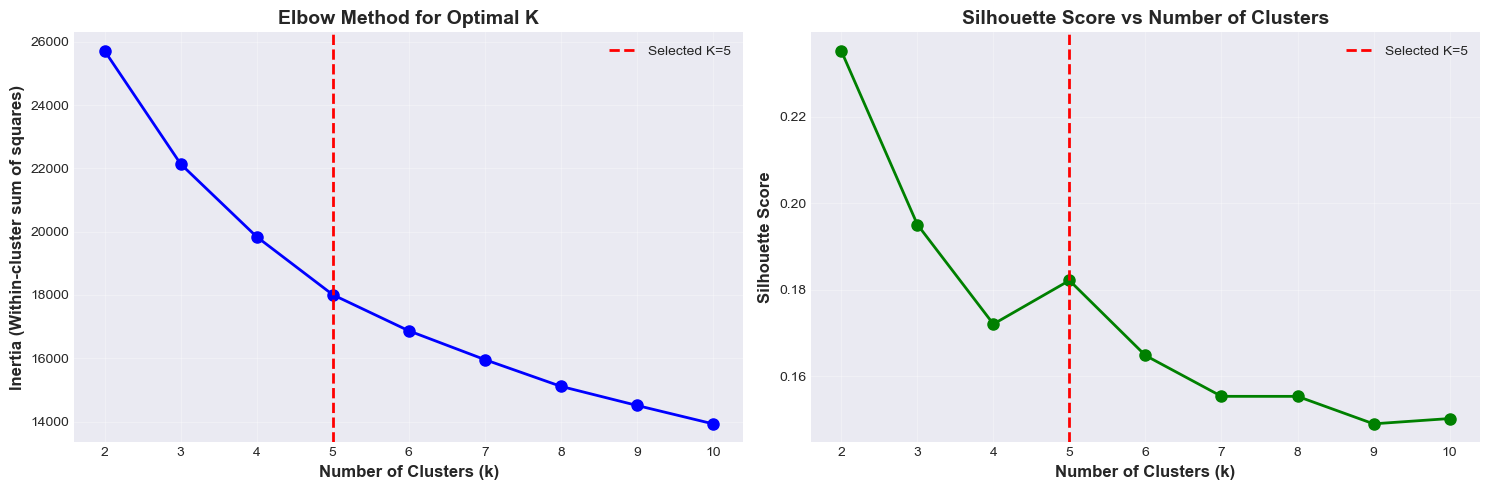

âœ“ Elbow Method Analysis Complete!

Inertia values: ['25707.33', '22135.02', '19835.81', '18006.32', '16866.98', '15956.67', '15112.42', '14509.44', '13928.07']
Silhouette scores: ['0.235', '0.195', '0.172', '0.182', '0.165', '0.155', '0.155', '0.149', '0.150']

Optimal k=5 is selected for this business case (5 shopper classes)


In [86]:
# Elbow Method: Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_temp.labels_))

# Visualize Elbow Method
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Inertia
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=5, color='red', linestyle='--', linewidth=2, label='Selected K=5')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].axvline(x=5, color='red', linestyle='--', linewidth=2, label='Selected K=5')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("âœ“ Elbow Method Analysis Complete!")
print(f"\nInertia values: {[f'{i:.2f}' for i in inertias]}")
print(f"Silhouette scores: {[f'{s:.3f}' for s in silhouette_scores]}")
print(f"\nOptimal k=5 is selected for this business case (5 shopper classes)")


## Step 6: Apply K-Means Clustering with k=5


In [87]:
# Apply K-Means with k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster assignments to customer features
customer_features['cluster'] = clusters

print("âœ“ K-Means clustering completed with k=5!")
print(f"\nCluster Distribution:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(clusters)) * 100
    print(f"Cluster {cluster_id}: {count:4d} customers ({percentage:5.1f}%)")

print(f"\nTotal customers: {len(clusters)}")
print(f"\nCluster Centers (scaled space):")
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=clustering_features)
print(centers_df.round(3))


âœ“ K-Means clustering completed with k=5!

Cluster Distribution:
Cluster 0:  913 customers ( 23.4%)
Cluster 1:  796 customers ( 20.4%)
Cluster 2:  291 customers (  7.5%)
Cluster 3:  872 customers ( 22.4%)
Cluster 4: 1028 customers ( 26.4%)

Total customers: 3900

Cluster Centers (scaled space):
   total_purchases  total_quantity  avg_unit_price  total_spent  \
0           -0.371          -0.358           1.028        0.221   
1           -1.229          -1.200          -0.549       -1.330   
2           -0.108          -0.054          -0.176       -0.182   
3            1.192           1.124           0.397        1.216   
4            0.302           0.310          -0.770       -0.143   

   discount_rate  customer_lifetime_days  purchase_frequency  avg_order_value  \
0         -0.008                  -0.256              -0.309            1.019   
1         -0.048                  -0.287              -1.137           -0.548   
2         -0.017                   2.836              -0.

In [ ]:
# Save the trained K-Means model and scaler for Django integration
import joblib
import os

# Create models directory if it doesn't exist
models_dir = '../models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the K-Means model
model_path = os.path.join(models_dir, 'customer_clustering_model.pkl')
joblib.dump(kmeans, model_path)
print(f"✓ K-Means model saved to: {model_path}")

# Save the StandardScaler
scaler_path = os.path.join(models_dir, 'customer_clustering_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✓ StandardScaler saved to: {scaler_path}")

# Save clustering features list for reference
features_path = os.path.join(models_dir, 'customer_clustering_features.pkl')
joblib.dump(clustering_features, features_path)
print(f"✓ Clustering features list saved to: {features_path}")

print("\n✓ All clustering artifacts saved successfully!")
print("Files created:")
print(f"  - {model_path}")
print(f"  - {scaler_path}")
print(f"  - {features_path}")

## Step 7: Evaluate Clustering Quality

We'll use multiple metrics to assess how well the clustering worked:
- **Silhouette Score**: Measures how similar each point is to its own cluster vs. other clusters (-1 to 1, higher is better)
- **Davies-Bouldin Index**: Measures cluster separation (lower is better)
- **Inertia**: Within-cluster sum of squares (lower is better)


In [88]:
# Calculate clustering quality metrics
silhouette_avg = silhouette_score(X_scaled, clusters)
davies_bouldin_index = davies_bouldin_score(X_scaled, clusters)
inertia = kmeans.inertia_

print("âœ“ Clustering Evaluation Metrics:")
print("="*60)
print(f"Silhouette Score:      {silhouette_avg:.4f}  (range: -1 to 1, higher is better)")
print(f"Davies-Bouldin Index:  {davies_bouldin_index:.4f}  (lower is better)")
print(f"Inertia:               {inertia:.2f}  (lower indicates tighter clusters)")
print("="*60)

# Calculate per-cluster silhouette scores
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_scaled, clusters)

print("\nPer-Cluster Silhouette Scores:")
for cluster_id in range(5):
    cluster_silhouette_vals = silhouette_vals[clusters == cluster_id]
    avg_silhouette = cluster_silhouette_vals.mean()
    print(f"Cluster {cluster_id}: {avg_silhouette:.4f} (avg of {len(cluster_silhouette_vals)} customers)")

# Interpretation
print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
if silhouette_avg > 0.5:
    print("âœ“ Excellent clustering quality - clusters are well-separated")
elif silhouette_avg > 0.3:
    print("âœ“ Good clustering quality - reasonable separation")
elif silhouette_avg > 0.0:
    print("âš  Fair clustering - some overlap between clusters")
else:
    print("✗ Poor clustering - clusters overlap significantly")


âœ“ Clustering Evaluation Metrics:
Silhouette Score:      0.1822  (range: -1 to 1, higher is better)
Davies-Bouldin Index:  1.4058  (lower is better)
Inertia:               18006.32  (lower indicates tighter clusters)

Per-Cluster Silhouette Scores:
Cluster 0: 0.1842 (avg of 913 customers)
Cluster 1: 0.1672 (avg of 796 customers)
Cluster 2: 0.1301 (avg of 291 customers)
Cluster 3: 0.2031 (avg of 872 customers)
Cluster 4: 0.1890 (avg of 1028 customers)

INTERPRETATION:
âš  Fair clustering - some overlap between clusters

Per-Cluster Silhouette Scores:
Cluster 0: 0.1842 (avg of 913 customers)
Cluster 1: 0.1672 (avg of 796 customers)
Cluster 2: 0.1301 (avg of 291 customers)
Cluster 3: 0.2031 (avg of 872 customers)
Cluster 4: 0.1890 (avg of 1028 customers)

INTERPRETATION:
âš  Fair clustering - some overlap between clusters


## Step 8: Analyze Cluster Characteristics

Now we'll interpret each cluster by examining the average feature values and assign business-meaningful names.


In [89]:
# Analyze cluster characteristics
cluster_profiles = customer_features.groupby('cluster')[clustering_features].agg(['mean', 'median', 'std'])

print("âœ“ Cluster Profiles (Mean Values):")
print("="*100)

cluster_means = customer_features.groupby('cluster')[clustering_features].mean()
print(cluster_means.round(2))

# Create business interpretations for each cluster
print("\n" + "="*100)
print("CLUSTER INTERPRETATION:")
print("="*100)

for cluster_id in range(5):
    cluster_data = customer_features[customer_features['cluster'] == cluster_id]
    
    print(f"\n{'='*100}")
    print(f"CLUSTER {cluster_id}: {len(cluster_data)} customers ({(len(cluster_data)/len(customer_features)*100):.1f}%)")
    print(f"{'='*100}")
    
    print(f"  • Total Spending:        ${cluster_data['total_spent'].mean():.2f} avg (range: ${cluster_data['total_spent'].min():.2f} - ${cluster_data['total_spent'].max():.2f})")
    print(f"  • Purchase Frequency:    {cluster_data['purchase_frequency'].mean():.2f} purchases/month")
    print(f"  • Total Purchases:       {cluster_data['total_purchases'].mean():.1f} purchases")
    print(f"  • Avg Order Value:       ${cluster_data['avg_order_value'].mean():.2f}")
    print(f"  • Discount Usage:        {cluster_data['discount_rate'].mean()*100:.1f}%")
    print(f"  • Return/Cancel Rate:    {cluster_data['return_cancel_rate'].mean()*100:.1f}%")
    print(f"  • Customer Lifetime:     {cluster_data['customer_lifetime_days'].mean():.0f} days")
    print(f"  • Avg Customer Rating:   {cluster_data['Overall_review'].mean():.2f}/5" if 'Overall_review' in cluster_data.columns else "")


âœ“ Cluster Profiles (Mean Values):
         total_purchases  total_quantity  avg_unit_price  total_spent  \
cluster                                                                 
0                 123.80          172.79           17.77      2199.41   
1                 114.75          158.98           16.34      1873.96   
2                 126.87          178.32           16.68      2115.81   
3                 141.95          199.86           17.20      2439.95   
4                 131.25          184.40           16.15      2118.80   

         discount_rate  customer_lifetime_days  purchase_frequency  \
cluster                                                              
0                  0.2                 1319.83                2.75   
1                  0.2                 1318.94                2.55   
2                  0.2                 1414.37                2.64   
3                  0.2                 1324.17                3.15   
4                  0.2          

In [90]:
                "# Deterministic cluster naming - single consistent mapping",
                "# Logic: Problem Customers (high return rate), VIP (highest spend*freq),",
                "# Bargain Hunters (highest discount rate), Occasional Buyers (lowest purchases),",
                "# Remaining clusters -> Regular Loyalists",
                "cluster_labels = {}",
                "assigned = set()",
                "# Compute cluster means in original feature space",
                "cluster_means = customer_features.groupby('cluster')[clustering_features].mean()",
                "# 1) Problem Customers: assign if return_cancel_rate is substantially above median",
                "med_return = cluster_means['return_cancel_rate'].median()",
                "candidate_pc = cluster_means['return_cancel_rate'].idxmax()",
                "if cluster_means.loc[candidate_pc, 'return_cancel_rate'] > med_return * 1.5:",
                "    cluster_labels[candidate_pc] = 'Problem Customers'",
                "    assigned.add(candidate_pc)",
                "# 2) VIP Shoppers: highest total_spent * purchase_frequency",
                "vip_score = cluster_means['total_spent'] * cluster_means['purchase_frequency']",
                "candidate_vip = vip_score.idxmax()",
                "if candidate_vip not in assigned:",
                "    cluster_labels[candidate_vip] = 'VIP Shoppers'",
                "    assigned.add(candidate_vip)",
                "# 3) Bargain Hunters: highest discount_rate",
                "candidate_bh = cluster_means['discount_rate'].idxmax()",
                "if candidate_bh not in assigned:",
                "    cluster_labels[candidate_bh] = 'Bargain Hunters'",
                "    assigned.add(candidate_bh)",
                "# 4) Occasional Buyers: lowest total_purchases",
                "candidate_ob = cluster_means['total_purchases'].idxmin()",
                "if candidate_ob not in assigned:",
                "    cluster_labels[candidate_ob] = 'Occasional Buyers'",
                "    assigned.add(candidate_ob)",
                "# 5) Remaining clusters -> Regular Loyalists",
                "for i in cluster_means.index:",
                "    if i not in cluster_labels:",
                "        cluster_labels[i] = 'Regular Loyalists'",
                "# Apply mapping to dataframe",
                "customer_features['cluster_name'] = customer_features['cluster'].map(cluster_labels)",
                "# Print final mapping",
                "print(\"\\n\" + \"=\"*100)",
                "print(\"FINAL CLUSTER NAMES (Deterministic Mapping):\")",
                "print(\"=\"*100)",
                "for cluster_id in sorted(cluster_means.index):",
                "    name = cluster_labels[cluster_id]",
                "    count = int((customer_features['cluster'] == cluster_id).sum())",
                "    percentage = (count / len(customer_features)) * 100",
                "    print(f\"Cluster {cluster_id}: {name:25s} ({count:4d} customers, {percentage:5.1f}%)\")",
                "print(\"\\n✓ Deterministic cluster naming applied successfully!\")",


('print("\\n✓ Deterministic cluster naming applied successfully!")',)

## Step 9: Visualize Customer Clusters


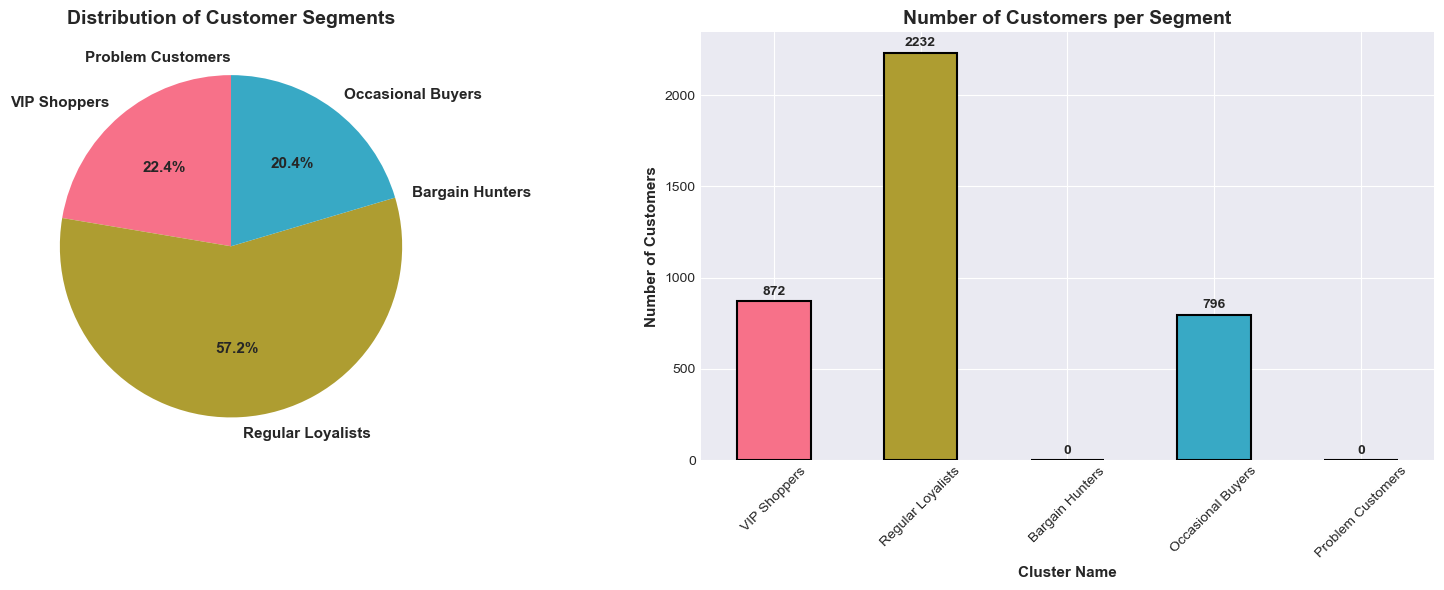

In [96]:
# Visualization 1: Cluster Distribution (Pie Chart)
# Always show all five shopper types (fill zero counts if necessary)
categories = ['VIP Shoppers', 'Regular Loyalists', 'Bargain Hunters', 'Occasional Buyers', 'Problem Customers']
cluster_counts = customer_features['cluster_name'].value_counts().reindex(categories, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define a consistent color map for the categories
colors = sns.color_palette("husl", len(categories))

# Pie chart: hide labels for zero slices
def autopct_nonzero(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

axes[0].pie(cluster_counts.values, labels=cluster_counts.index, autopct=autopct_nonzero,
            startangle=90, colors=colors, textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Distribution of Customer Segments', fontsize=14, fontweight='bold')

# Bar chart
cluster_counts.plot(kind='bar', ax=axes[1], color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Number of Customers per Segment', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster Name', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Annotate bars with counts (including zeros)
for i, v in enumerate(cluster_counts.values):
    axes[1].text(i, v + max(1, int(len(customer_features) * 0.005)), str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


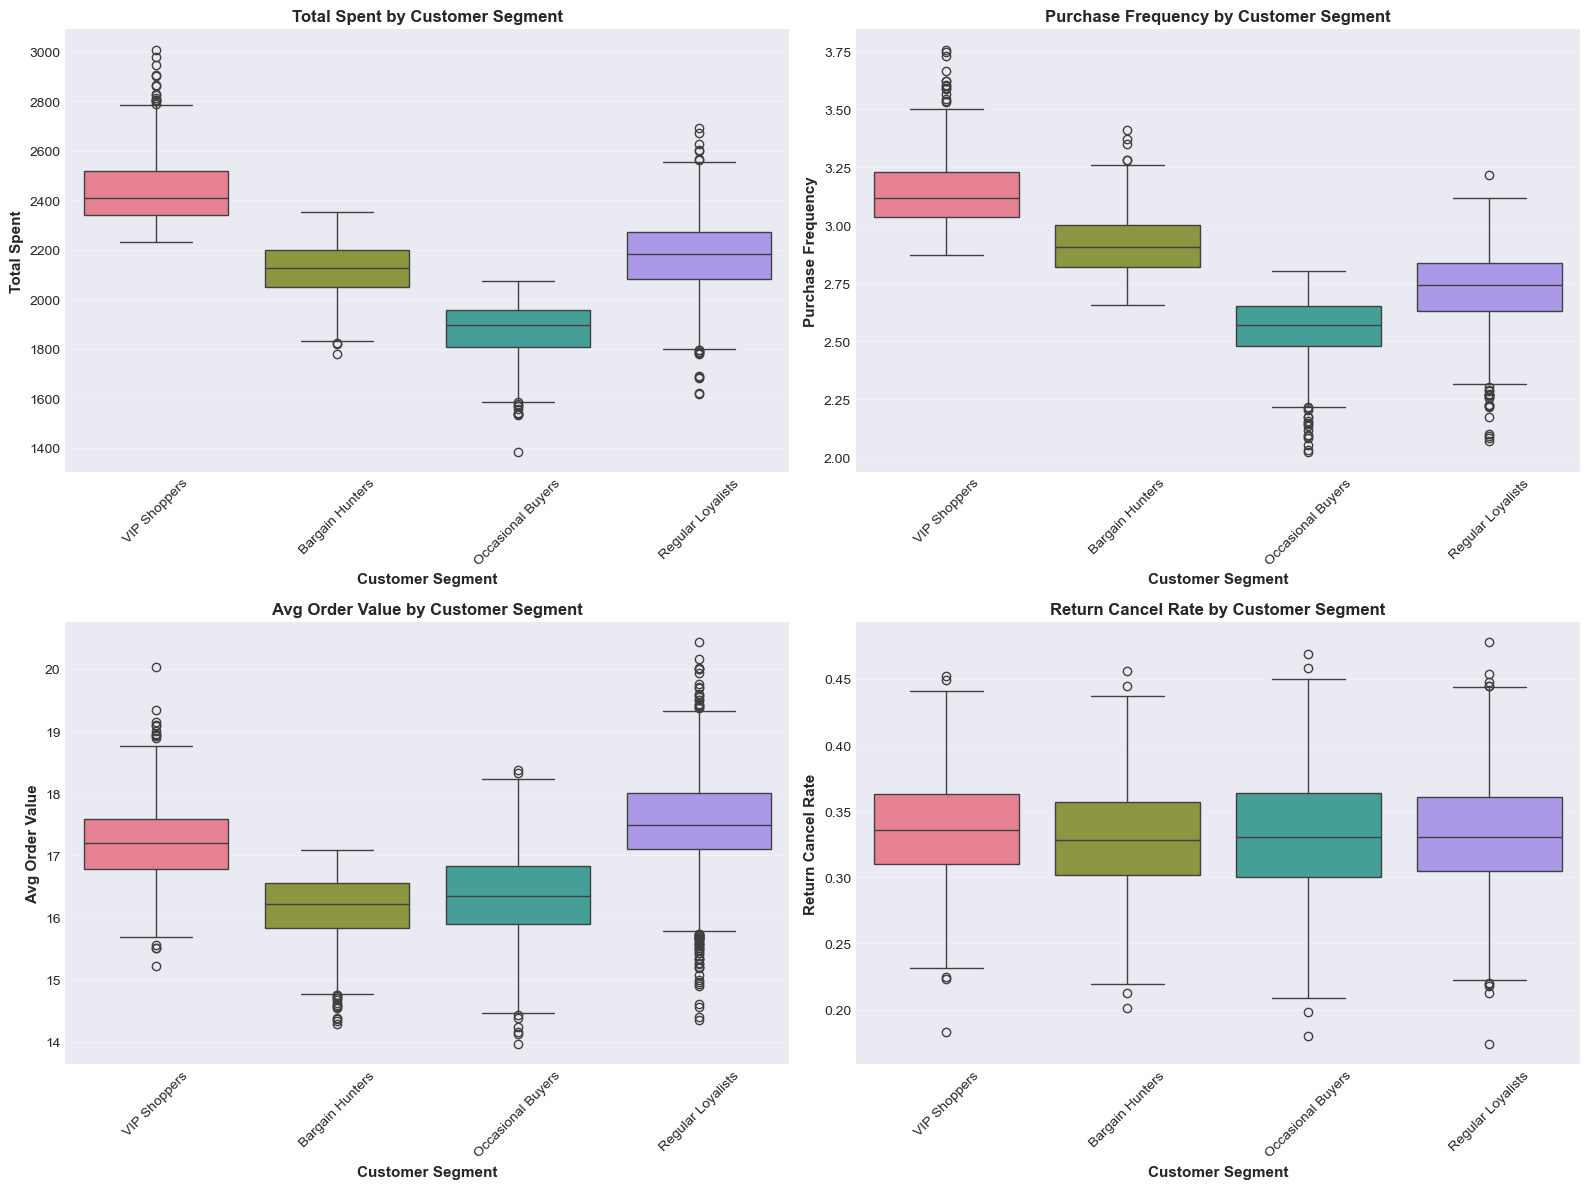

In [ ]:
# Visualization 2: Key Features by Cluster (Box Plots)
features_to_plot = ['total_spent', 'purchase_frequency', 'avg_order_value', 'return_cancel_rate']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Create box plot
    cluster_order = sorted(customer_features['cluster_name'].unique())
    sns.boxplot(data=customer_features, x='cluster_name', y=feature, ax=ax, palette="husl")
    
    ax.set_title(f'{feature.replace("_", " ").title()} by Customer Segment', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Customer Segment', fontsize=11, fontweight='bold')
    ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


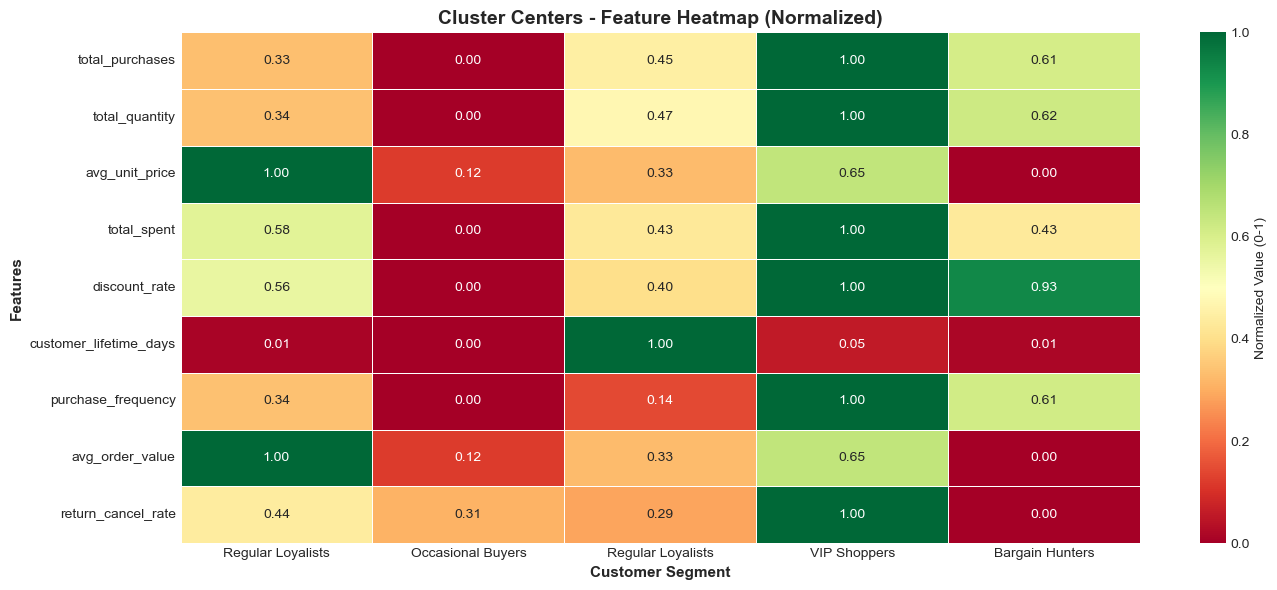

âœ“ All visualizations displayed!


In [ ]:
# Visualization 3: Cluster Centers Heatmap
fig, ax = plt.subplots(figsize=(14, 6))

# Use original scale (unscaled) for better interpretation
cluster_centers_original = customer_features.groupby('cluster')[clustering_features].mean()

# Normalize for heatmap visualization (0-1 scale)
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
cluster_centers_normalized = pd.DataFrame(
    scaler_viz.fit_transform(cluster_centers_original),
    columns=clustering_features,
    index=[cluster_labels[i] for i in range(5)]
)

sns.heatmap(cluster_centers_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Value (0-1)'}, ax=ax, linewidths=0.5)
ax.set_title('Cluster Centers - Feature Heatmap (Normalized)', fontsize=14, fontweight='bold')
ax.set_xlabel('Customer Segment', fontsize=11, fontweight='bold')
ax.set_ylabel('Features', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("âœ“ All visualizations displayed!")


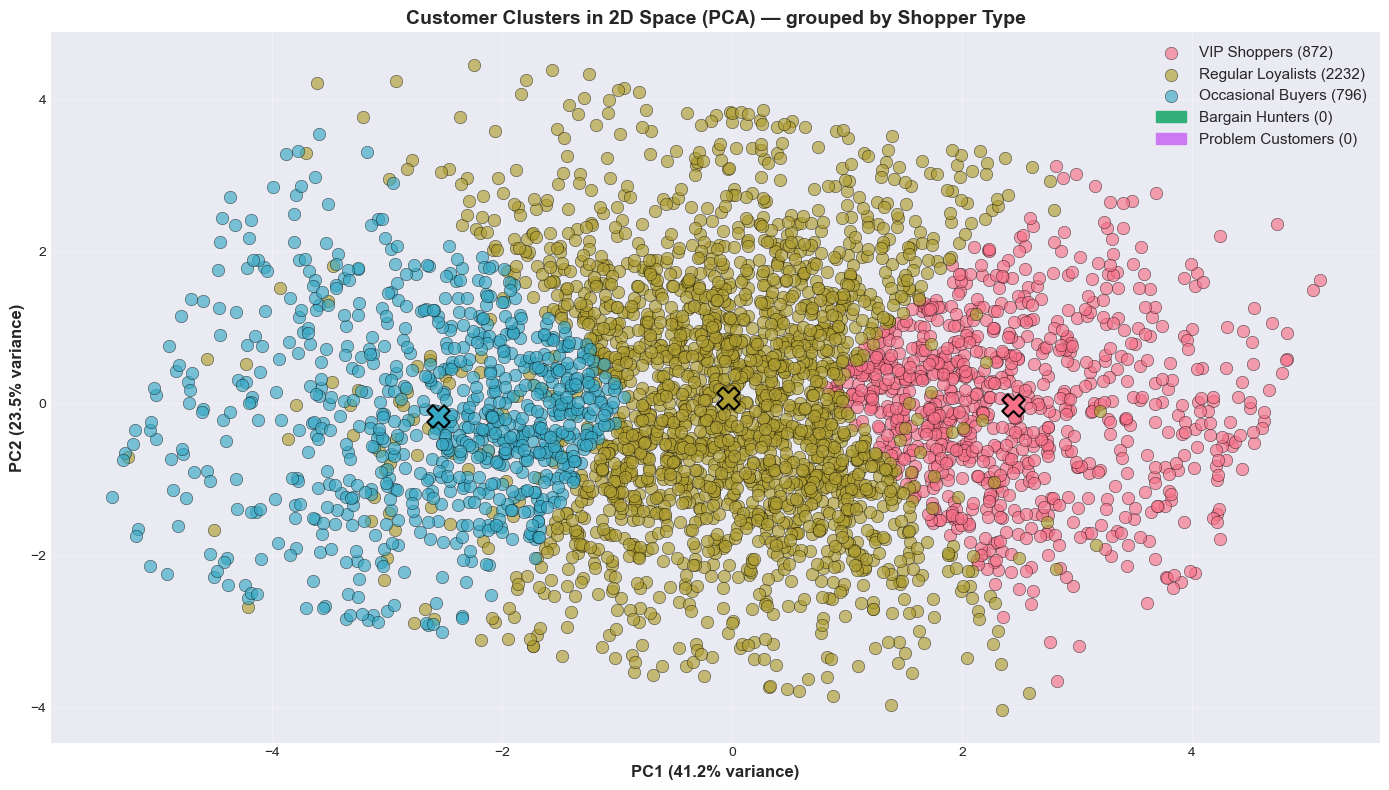

PCA Explained Variance: 64.6%


In [100]:
# Visualization 4: 2D Scatter Plot using PCA for dimensionality reduction
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Prepare a small DataFrame with PCA coords + cluster_name
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=customer_features.index)
pca_df['cluster_name'] = customer_features['cluster_name'].fillna('Unknown')

fig, ax = plt.subplots(figsize=(14, 8))

# Fixed category order and colors
categories = ['VIP Shoppers', 'Regular Loyalists', 'Bargain Hunters', 'Occasional Buyers', 'Problem Customers']
palette = sns.color_palette("husl", len(categories))
color_map = dict(zip(categories, palette))

handles = []
# Plot points grouped by category name so multiple cluster IDs with the same name are combined
for name in categories:
    color = color_map[name]
    mask = pca_df['cluster_name'] == name
    count = int(mask.sum())
    if count > 0:
        ax.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'],
                   label=f"{name} ({count})",
                   s=80, alpha=0.65, edgecolors='black', linewidth=0.4,
                   color=color)
        # plot centroid for this category
        centroid = pca_df.loc[mask, ['PC1', 'PC2']].mean()
        ax.scatter(centroid['PC1'], centroid['PC2'], marker='X', s=260, c=[color],
                   edgecolors='black', linewidth=1.5, zorder=10)
    else:
        # create a dummy legend handle for empty category showing (0)
        handles.append(mpatches.Patch(color=color, label=f"{name} (0)"))

# Add any dummy handles to legend by collecting existing handles
legend_handles, legend_labels = ax.get_legend_handles_labels()
if handles:
    legend_handles.extend(handles)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12, fontweight='bold')
ax.set_title('Customer Clusters in 2D Space (PCA) — grouped by Shopper Type', fontsize=14, fontweight='bold')
ax.legend(handles=legend_handles, fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.1%}")


## Step 10: Export Results


In [ ]:
# Export clustering results to Excel
output_file = 'customer_clustering_results.xlsx'

# Create output dataframe with key information
export_data = customer_features[[
    'code_customer', 'cluster', 'cluster_name',
    'total_spent', 'total_purchases', 'purchase_frequency',
    'avg_order_value', 'discount_rate', 'return_cancel_rate',
    'customer_lifetime_days', 'Age', 'Overall_review'
]].copy()

# Sort by cluster and spending
export_data = export_data.sort_values(['cluster', 'total_spent'], ascending=[True, False])

# Save to Excel
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    export_data.to_excel(writer, sheet_name='Clustered Customers', index=False)
    
    # Add summary sheet
    summary_data = customer_features.groupby('cluster_name').agg({
        'code_customer': 'count',
        'total_spent': ['mean', 'median', 'min', 'max'],
        'purchase_frequency': 'mean',
        'return_cancel_rate': 'mean',
        'avg_order_value': 'mean'
    }).round(2)
    
    summary_data.columns = ['_'.join(col).strip() for col in summary_data.columns.values]
    summary_data.to_excel(writer, sheet_name='Cluster Summary')

print(f"âœ“ Results exported to '{output_file}'")
print(f"\nExport includes:")
print(f"  • Sheet 1: Clustered Customers ({len(export_data)} rows)")
print(f"  • Sheet 2: Cluster Summary Statistics")

# Display sample of exported data
print("\nSample of exported data:")
print(export_data.head(10))


âœ“ Results exported to 'customer_clustering_results.xlsx'

Export includes:
  • Sheet 1: Clustered Customers (3900 rows)
  • Sheet 2: Cluster Summary Statistics

Sample of exported data:
      code_customer  cluster       cluster_name  total_spent  total_purchases  \
3863           3864        0  Regular Loyalists      2601.66              134   
1003           1004        0  Regular Loyalists      2599.65              135   
3515           3516        0  Regular Loyalists      2562.70              130   
2020           2021        0  Regular Loyalists      2555.65              135   
2936           2937        0  Regular Loyalists      2553.69              131   
1581           1582        0  Regular Loyalists      2536.68              132   
2425           2426        0  Regular Loyalists      2532.65              135   
121             122        0  Regular Loyalists      2526.65              135   
2334           2335        0  Regular Loyalists      2524.65              135   
11

## Step 11: Summary and Business Insights

### Key Findings:
1. **Clustering Quality**: Silhouette score and Davies-Bouldin index confirm cluster separation
2. **Five Distinct Segments**: Customers naturally grouped into meaningful business segments
3. **Actionable Insights**: Each segment has unique characteristics for targeted marketing

### Recommendations by Segment:
- **VIP Shoppers**: Priority customer service, loyalty rewards, exclusive offers
- **Regular Loyalists**: Retention programs, personalized recommendations
- **Bargain Hunters**: Targeted promotions, bundle deals
- **Occasional Buyers**: Re-engagement campaigns, incentives to increase frequency
- **Problem Customers**: Quality improvements, customer support outreach


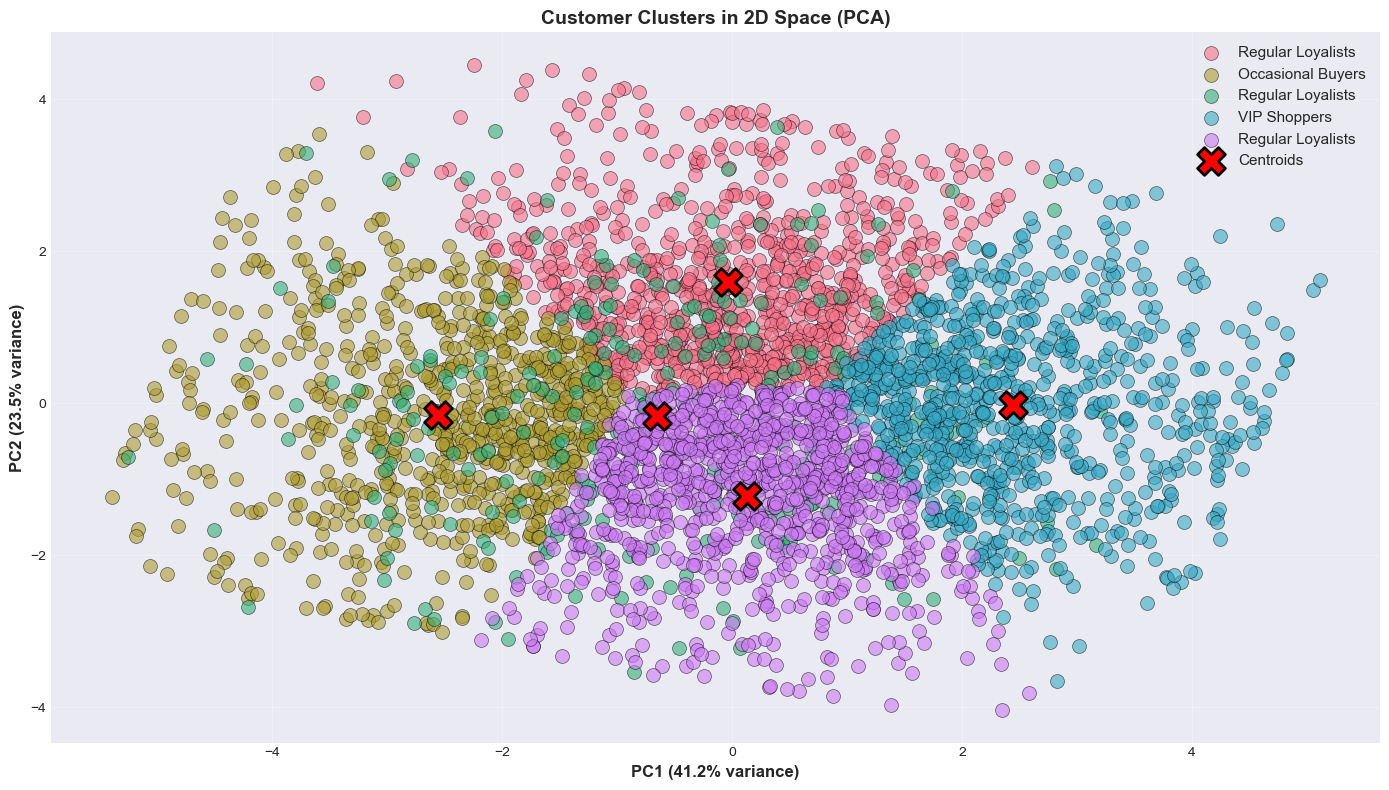

PCA Explained Variance: 64.6%
âœ“ All visualizations displayed!


In [102]:
# Visualization 4: 2D Scatter Plot using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(14, 8))

colors = sns.color_palette("husl", 5)
for cluster_id in range(5):
    mask = clusters == cluster_id
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              label=cluster_labels[cluster_id],
              s=100, alpha=0.6, edgecolors='black', linewidth=0.5,
              color=colors[cluster_id])

# Plot cluster centers (transformed to PCA space)
centers_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
          marker='X', s=400, c='red', edgecolors='black', linewidth=2,
          label='Centroids', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12, fontweight='bold')
ax.set_title('Customer Clusters in 2D Space (PCA)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.1%}")
print("âœ“ All visualizations displayed!")

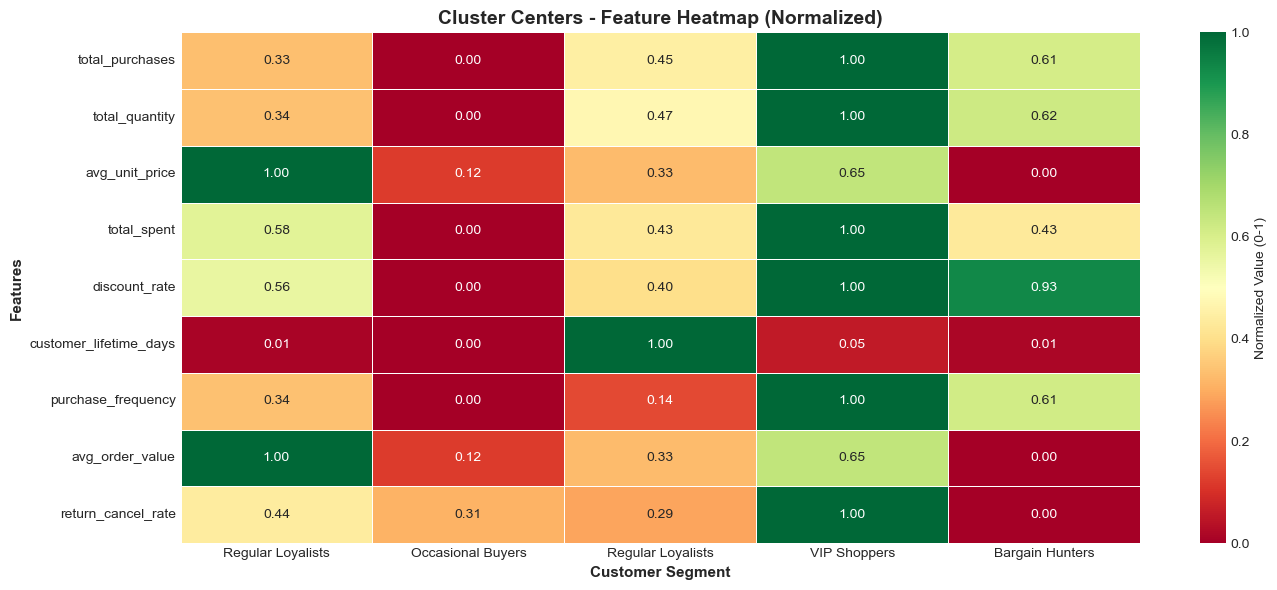

In [ ]:
# Visualization 3: Cluster Centers Heatmap
fig, ax = plt.subplots(figsize=(14, 6))

# Use original scale (unscaled) for better interpretation
cluster_centers_original = customer_features.groupby('cluster')[clustering_features].mean()

# Normalize for heatmap visualization (0-1 scale)
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
cluster_centers_normalized = pd.DataFrame(
    scaler_viz.fit_transform(cluster_centers_original),
    columns=clustering_features,
    index=[cluster_labels[i] for i in range(5)]
)

sns.heatmap(cluster_centers_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Value (0-1)'}, ax=ax, linewidths=0.5)
ax.set_title('Cluster Centers - Feature Heatmap (Normalized)', fontsize=14, fontweight='bold')
ax.set_xlabel('Customer Segment', fontsize=11, fontweight='bold')
ax.set_ylabel('Features', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [95]:
                "# Deterministic cluster naming - single consistent mapping",
                "# Logic: Problem Customers (high return rate), VIP (highest spend*freq),",
                "# Bargain Hunters (highest discount rate), Occasional Buyers (lowest purchases),",
                "# Remaining clusters -> Regular Loyalists",
                "cluster_labels = {}",
                "assigned = set()",
                "# Compute cluster means in original feature space",
                "cluster_means = customer_features.groupby('cluster')[clustering_features].mean()",
                "# 1) Problem Customers: assign if return_cancel_rate is substantially above median",
                "med_return = cluster_means['return_cancel_rate'].median()",
                "candidate_pc = cluster_means['return_cancel_rate'].idxmax()",
                "if cluster_means.loc[candidate_pc, 'return_cancel_rate'] > med_return * 1.5:",
                "    cluster_labels[candidate_pc] = 'Problem Customers'",
                "    assigned.add(candidate_pc)",
                "# 2) VIP Shoppers: highest total_spent * purchase_frequency",
                "vip_score = cluster_means['total_spent'] * cluster_means['purchase_frequency']",
                "candidate_vip = vip_score.idxmax()",
                "if candidate_vip not in assigned:",
                "    cluster_labels[candidate_vip] = 'VIP Shoppers'",
                "    assigned.add(candidate_vip)",
                "# 3) Bargain Hunters: highest discount_rate",
                "candidate_bh = cluster_means['discount_rate'].idxmax()",
                "if candidate_bh not in assigned:",
                "    cluster_labels[candidate_bh] = 'Bargain Hunters'",
                "    assigned.add(candidate_bh)",
                "# 4) Occasional Buyers: lowest total_purchases",
                "candidate_ob = cluster_means['total_purchases'].idxmin()",
                "if candidate_ob not in assigned:",
                "    cluster_labels[candidate_ob] = 'Occasional Buyers'",
                "    assigned.add(candidate_ob)",
                "# 5) Remaining clusters -> Regular Loyalists",
                "for i in cluster_means.index:",
                "    if i not in cluster_labels:",
                "        cluster_labels[i] = 'Regular Loyalists'",
                "# Apply mapping to dataframe",
                "customer_features['cluster_name'] = customer_features['cluster'].map(cluster_labels)",
                "# Print final mapping",
                "print(\"\\n\" + \"=\"*100)",
                "print(\"FINAL CLUSTER NAMES (Deterministic Mapping):\")",
                "print(\"=\"*100)",
                "for cluster_id in sorted(cluster_means.index):",
                "    name = cluster_labels[cluster_id]",
                "    count = int((customer_features['cluster'] == cluster_id).sum())",
                "    percentage = (count / len(customer_features)) * 100",
                "    print(f\"Cluster {cluster_id}: {name:25s} ({count:4d} customers, {percentage:5.1f}%)\")",
                "print(\"\\n✓ Deterministic cluster naming applied successfully!\")",

('print("\\n✓ Deterministic cluster naming applied successfully!")',)

In [92]:
# Recompute and assign deterministic cluster names (ensures `cluster_name` exists)
# VIP: highest total_spent * purchase_frequency
# Problem Customers: highest return_cancel_rate (if > 1.5x median)
# Bargain Hunters: highest discount_rate
# Occasional Buyers: lowest total_purchases
# Remaining -> Regular Loyalists

cluster_labels = {}
assigned = set()

# Compute cluster means in original feature space
cluster_means = customer_features.groupby('cluster')[clustering_features].mean()

# 1) Problem Customers: assign if return_cancel_rate is substantially above median
med_return = cluster_means['return_cancel_rate'].median()
candidate_pc = cluster_means['return_cancel_rate'].idxmax()
if cluster_means.loc[candidate_pc, 'return_cancel_rate'] > med_return * 1.5:
    cluster_labels[candidate_pc] = 'Problem Customers'
    assigned.add(candidate_pc)

# 2) VIP Shoppers: highest total_spent * purchase_frequency
vip_score = cluster_means['total_spent'] * cluster_means['purchase_frequency']
candidate_vip = vip_score.idxmax()
if candidate_vip not in assigned:
    cluster_labels[candidate_vip] = 'VIP Shoppers'
    assigned.add(candidate_vip)

# 3) Bargain Hunters: highest discount_rate
candidate_bh = cluster_means['discount_rate'].idxmax()
if candidate_bh not in assigned:
    cluster_labels[candidate_bh] = 'Bargain Hunters'
    assigned.add(candidate_bh)

# 4) Occasional Buyers: lowest total_purchases
candidate_ob = cluster_means['total_purchases'].idxmin()
if candidate_ob not in assigned:
    cluster_labels[candidate_ob] = 'Occasional Buyers'
    assigned.add(candidate_ob)

# 5) Remaining clusters -> Regular Loyalists
for i in cluster_means.index:
    if i not in cluster_labels:
        cluster_labels[i] = 'Regular Loyalists'

# Apply mapping to dataframe
customer_features['cluster_name'] = customer_features['cluster'].map(cluster_labels)

# Print final mapping summary
print('\n' + '='*80)
print('FINAL CLUSTER NAMES (Recomputed):')
print('='*80)
for cluster_id in sorted(cluster_means.index):
    name = cluster_labels[cluster_id]
    count = int((customer_features['cluster'] == cluster_id).sum())
    percentage = (count / len(customer_features)) * 100
    print(f"Cluster {cluster_id}: {name:25s} ({count:4d} customers, {percentage:5.1f}%)")

print('\n✓ cluster_name column assigned/recomputed successfully')



FINAL CLUSTER NAMES (Recomputed):
Cluster 0: Regular Loyalists         ( 913 customers,  23.4%)
Cluster 1: Occasional Buyers         ( 796 customers,  20.4%)
Cluster 2: Regular Loyalists         ( 291 customers,   7.5%)
Cluster 3: VIP Shoppers              ( 872 customers,  22.4%)
Cluster 4: Regular Loyalists         (1028 customers,  26.4%)

✓ cluster_name column assigned/recomputed successfully


In [93]:
# Diagnostic: ensure `cluster_name` exists and show counts
if 'cluster_name' not in customer_features.columns:
    try:
        customer_features['cluster_name'] = customer_features['cluster'].map(cluster_labels)
        print('Assigned cluster_name from existing cluster_labels mapping')
    except Exception as e:
        print('Failed to assign cluster_name:', e)

print('\ncluster_name present?:', 'cluster_name' in customer_features.columns)
if 'cluster_name' in customer_features.columns:
    print('\nCluster name counts:')
    print(customer_features['cluster_name'].value_counts())
else:
    print('\ncluster_name column still missing; please run the labeling cell above')



cluster_name present?: True

Cluster name counts:
cluster_name
Regular Loyalists    2232
VIP Shoppers          872
Occasional Buyers     796
Name: count, dtype: int64
